# Mount To Drive & Import Libraries

In [3]:
# CHANGE THIS TO YOUR DIRECTORY
embedding_dir = '/content/drive/MyDrive/exampleEmbeddings'
# embedding_dir = "/content/drive/MyDrive/11785_Project/Programming/embeddings/NathanDistilBERT"
# embedding_dir = "/content/drive/MyDrive/11785_Project/Programming/embeddings/NathanDistilBERT/embeddings-variant"
# CHANGE THIS TO YOUR EMBEDDING WIDTH
embedding_width = 768

import os
from google.colab import drive
drive.mount("/content/drive")

embedding_files = os.listdir(embedding_dir)
embedding_files = [f for f in embedding_files if f.endswith('.json')]
# embedding_files = [f for f in embedding_files if not f.startswith('hidden')]
# embedding_files = [f for f in embedding_files if not f.startswith('attention')]

print(f'Running downstream tasks on the following embedding files:')
for f in embedding_files:
    print(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running downstream tasks on the following embedding files:
hidden_last_6_layer_0.75.json
cls_embeddings_0.0_distilbert-base-cased_BASELINE_1651420556.json


In [ ]:
import pandas
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

!pip install sentence_transformers

from sentence_transformers import SentenceTransformer

# Phrasebank DataLoader

In [5]:
# For Downstream Data - Phrasebank
!mkdir downstream_data_zip
!mkdir downstream_data

!cp /content/drive/MyDrive/11785_Project/Programming/Data/phrasebank.zip downstream_data_zip

!unzip -q downstream_data_zip/*.zip -d downstream_data

In [6]:
from pandas.core.frame import DataFrame
class LibriSamplesPhrasebank(torch.utils.data.Dataset):
    def __init__(self, data:DataFrame, convert_label_to_int=True, return_labels=False, sentence_to_vec:dict=None):
        """
        data:DataFrame
            This is the data split from the all-data.csv in the Financial Phrase Bank
        
        convert_label_to_int:bool
            If this is true, then:
                 negative = -1
                 neutral  =  0
                 positive =  1
        
        sentence_to_vec:dict
            If this value is present, then dictionary of sentence to vector mappings.
        """
        # Simply reading in the csv
        self.X = data["sentence"].to_numpy()
        self.unresolved = set()
        # Convert the sentences to vectors if a dictionary is provided
        if sentence_to_vec != None:
            new_X = []
            for sentence in self.X:
                vector = sentence_to_vec.get((sentence,), None)
                if vector == None:
                    # self.unresolved.add(sentence)
                    # print("The dictionary contains no vector for the sentence: \n{}".format(sentence))
                    # continue
                    raise Exception("The dictionary contains no vector for the sentence: \n{}".format(sentence))
                    return
                new_X.append(vector)
            self.X = np.array(new_X)
        else:
            new_X = []
            default_model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')
            for sentence in self.X:
                vector = default_model.encode(sentence) # numpy.array D=384
                new_X.append(torch.from_numpy(vector))
            self.X = np.array(new_X)

        # Check if we should be returning labels (Not necessary for generating the BERT Emedding)
        self.return_labels = return_labels
        if return_labels:
            self.Y = data["label"].to_numpy()
            # Probably will want to convert the data into numeric form for easier handling
            if convert_label_to_int:
                new_Y = np.ones(len(self.Y), dtype=np.int8)
                new_Y[self.Y == "negative"] = 0
                new_Y[self.Y == "positive"] = 2
                self.Y = torch.from_numpy(new_Y)

    def get_unresolved(self):
        return self.unresolved

    def __len__(self):
        """
        Get the size of the data.
        """
        return len(self.X)
    
    def __getitem__(self, ind):
        """
        if self.return_labels==True, then this will return the sentence and corresponding label,
        otherwise this will return only the sentence
        """
        if self.return_labels:
            return self.X[ind], self.Y[ind]
        else:
            return self.X[ind]

class LibriSamplesPhrasebankWordEmbedding(torch.utils.data.Dataset):
    def __init__(self, data:DataFrame, convert_label_to_int=True, return_labels=False, word_to_vec=None):
        """
        data:DataFrame
            This is the data split from the all-data.csv in the Financial Phrase Bank
        
        convert_label_to_int:bool
            If this is true, then:
                 negative = 0
                 neutral  = 1
                 positive = 2
        
        word_to_vec: lambda
            If this value is present, then dictionary of word to vector mappings.
        """
        # Simply reading in the csv
        self.X = data["sentence"].to_numpy()

        # Convert the sentences to vectors if a dictionary is provided
        if word_to_vec != None:
            new_X = []
            new_lenX = []
            for sentence in self.X:
                word_vec = []
                for word in sentence.split():
                    word = word.lower()
                    try:
                        vector = word_to_vec(word)
                        word_vec.append(vector)
                    except:
                        # print(f'Cannot embed: {word}')
                        pass

                    # if word in word_to_vec.keys():
                    #     vector = word_to_vec[word]
                    #     word_vec.append(vector)
                if len(word_vec) > 0:
                    new_X.append(np.array(word_vec))
                    new_lenX.append(len(word_vec))
                # else:
                #     print(f'could not recog any word in: {sentence}')
            self.X = np.array(new_X)

        # Check if we should be returning labels (Not necessary for generating the BERT Emedding)
        self.return_labels = return_labels
        if return_labels:
            self.Y = data["label"].to_numpy()
            # Probably will want to convert the data into numeric form for easier handling
            if convert_label_to_int:
                new_Y = np.ones(len(self.Y), dtype=np.int64)
                new_Y[self.Y == "negative"] = 0
                new_Y[self.Y == "positive"] = 2
                self.Y = new_Y

    def __len__(self):
        """
        Get the size of the data.
        """
        return len(self.X)
    
    def __getitem__(self, ind):
        """
        if self.return_labels==True, then this will return the sentence and corresponding label,
        otherwise this will return only the sentence
        """
        if self.return_labels:
            return torch.from_numpy(self.X[ind]), self.Y[ind]
        else:
            return torch.from_numpy(self.X[ind])
    
    def labeled_collate_fn(batch):
        batch_x = [x for x,y in batch]
        batch_y = [y for x,y in batch]

        batch_x_pad = pad_sequence(batch_x, batch_first=True)
        lengths_x = [len(x) for x in batch_x]

        return batch_x_pad, torch.tensor(lengths_x), torch.tensor(batch_y)
    
    def unlabeled_collate_fn(batch):
        batch_x = batch

        batch_x_pad = pad_sequence(batch_x, batch_first=True)
        lengths_x = [len(x) for x in batch_x]

        return batch_x_pad, torch.tensor(lengths_x)

# Modelling

In [7]:
csv_path = "/content/downstream_data/all-data.csv"
df = pandas.read_csv(csv_path, encoding="ISO-8859-1", names=["label", "sentence"])

df_train, df_val = train_test_split(df, test_size = 0.1, random_state = 10)
len(df_train), len(df_val)

(4361, 485)

# Sentence Embedding

In [8]:
class SentenceModel(nn.Module):
    def __init__(self, embedding_size: int, classes: int):
        super(SentenceModel, self).__init__()
        self.classification = nn.Linear(
            in_features=embedding_size,
            out_features=classes,
        )
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, inputs_):
        x = self.classification(inputs_)
        x = self.softmax(x)
        return x

In [9]:
def train_model(model):
    torch.cuda.empty_cache()
    model.train()
    total_loss = 0
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train') 

    for i, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()

        x = x.cuda()
        y = y.type(torch.LongTensor)
        y = y.cuda()

        # Don't be surprised - we just wrap these two lines to make it work for FP16
        h = model(x)
        loss = criterion(h, y)

        # Update loss as we go
        total_loss += float(loss)

        lr = scheduler.get_last_lr()[0]
        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            lr="{:.04f}".format(float(lr)))
        
        # Another couple things you need for FP16. 
        loss.backward() # This is a replacement for loss.backward()
        optimizer.step() # This is a replacement for optimizer.step()
        batch_bar.update() # Update tqdm bar
    scheduler.step()
    batch_bar.close() # You need this to close the tqdm bar

    loss = float(total_loss / len(train_loader))
    print("Epoch {}/{}: Train Loss {:.04f}".format(
        epoch + 1,
        epochs,
        loss))

    return loss

def eval_model(model, return_info=False):
    torch.cuda.empty_cache()
    model.eval()
    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')
    dists = []
    correct = 0.0
    total = 0.0

    ground_truths = []
    raw_preds = []
    binary_preds = []
    for i, data in enumerate(val_loader):
        x, y = data
        x = x.cuda()
        y = y.type(torch.LongTensor)
        y = y.cuda()


        for val in y:
            new_ground_truth = [0] * 3
            new_ground_truth[val] = 1
            ground_truths.append(new_ground_truth)

        h = model(x)
        for j in range(h.shape[0]):
            raw_preds.append(h[j, :].cpu().detach().numpy().tolist())
        
        preds = torch.argmax(h, axis=1, keepdims=False)

        for val in preds:
            new_pred = [0] * 3
            new_pred[val] = 1
            binary_preds.append(new_pred)

        correct += (preds == y).float().sum()
        total += len(preds)
        batch_bar.update()
    
    batch_bar.close()
    raw_preds = np.array(raw_preds)
    binary_preds = np.array(binary_preds)

    ground_truths = np.array(ground_truths, dtype=bool)
    auc = roc_auc_score(ground_truths, raw_preds, multi_class='ovr', labels=["negative", "neutral", "positive"])
    score = correct / total
    print(f"Validation acc: {score}")
    print(f"Area Under Curve: {auc}")
    if return_info:
        return score, auc, ground_truths, binary_preds
    else:
        return score

In [11]:

results = []
model_ground_truths = dict()
model_predictions = dict()

for embedding_file in embedding_files:
    print(f'Training with embedding: {embedding_file}')
    lr = 1e-3
    epochs = 60
    classes = 3
    best_score = 0
    best_epoch = 0
    best_auc = 0
    best_predictions = None
    best_ground_truths = None

    sentence_to_vec = torch.load(f'{embedding_dir}/{embedding_file}')

    train_data = LibriSamplesPhrasebank(df_train, convert_label_to_int=True, return_labels=True, sentence_to_vec=sentence_to_vec)
    train_loader = DataLoader(train_data, batch_size=128)

    val_data = LibriSamplesPhrasebank(df_val, convert_label_to_int=True, return_labels=True, sentence_to_vec=sentence_to_vec)
    val_loader = DataLoader(val_data, batch_size=128)
    
    embedding_width = int(list(sentence_to_vec.values())[0].shape[0])
    model = SentenceModel(embedding_width, classes).cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # LR from https://arxiv.org/pdf/1903.10676.pdf
    # scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr*0.05, max_lr=lr, step_size_up=5*len(train_loader), cycle_momentum=False)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=lr*0.05)

    for epoch in range(epochs):
        lr = float(optimizer.param_groups[0]['lr'])
        loss = train_model(model)
        score, auc, ground_truths, binary_preds = eval_model(model, return_info=True)


        if score > best_score:
            best_score = score
            best_auc = auc
            best_epoch = epoch
            best_ground_truths = ground_truths
            best_predictions = binary_preds
    
    # Saving the outputs
    model_ground_truths[embedding_file] = best_ground_truths
    model_predictions[embedding_file] = best_predictions
    results.append((embedding_file, best_score, best_auc, best_epoch))

with open(f'{embedding_dir}/results.csv', 'w') as f:
    for file, score, auc, epoch in results:
        print(f'{file}: {score} at epoch: {epoch}')
        f.write(f'{file}, {score}, {auc}, {epoch}\n')

Training with embedding: hidden_last_6_layer_0.75.json


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch 1/60: Train Loss 0.9064


Validation acc: 0.701030969619751
Area Under Curve: 0.7231595798206417


Epoch 2/60: Train Loss 0.8582


Validation acc: 0.7134020924568176
Area Under Curve: 0.7462423699938024


Epoch 3/60: Train Loss 0.8414


Validation acc: 0.7216495275497437
Area Under Curve: 0.7506796527015981


Epoch 4/60: Train Loss 0.8301


Validation acc: 0.723711371421814
Area Under Curve: 0.751682221413215


Epoch 5/60: Train Loss 0.8214


Validation acc: 0.7195876836776733
Area Under Curve: 0.7493954965648788


Epoch 6/60: Train Loss 0.8155


Validation acc: 0.7175257802009583
Area Under Curve: 0.7509350641573954


Epoch 7/60: Train Loss 0.8107


Validation acc: 0.7175257802009583
Area Under Curve: 0.7550020412776307


Epoch 8/60: Train Loss 0.8071


Validation acc: 0.7195876836776733
Area Under Curve: 0.7607146737321041


Epoch 9/60: Train Loss 0.8043


Validation acc: 0.723711371421814
Area Under Curve: 0.7677733470583102


Epoch 10/60: Train Loss 0.8021


Validation acc: 0.7298969626426697
Area Under Curve: 0.7763936575052295


Epoch 11/60: Train Loss 0.7999


Validation acc: 0.7278350591659546
Area Under Curve: 0.7848064174094054


Epoch 12/60: Train Loss 0.7975


Validation acc: 0.7257732152938843
Area Under Curve: 0.7905533351922887


Epoch 13/60: Train Loss 0.7948


Validation acc: 0.7257732152938843
Area Under Curve: 0.7940642973780779


Epoch 14/60: Train Loss 0.7920


Validation acc: 0.7257732152938843
Area Under Curve: 0.7959793614516556


Epoch 15/60: Train Loss 0.7895


Validation acc: 0.723711371421814
Area Under Curve: 0.7970085611231337


Epoch 16/60: Train Loss 0.7872


Validation acc: 0.723711371421814
Area Under Curve: 0.7977745097047588


Epoch 17/60: Train Loss 0.7852


Validation acc: 0.7257732152938843
Area Under Curve: 0.7983257207547437


Epoch 18/60: Train Loss 0.7833


Validation acc: 0.7278350591659546
Area Under Curve: 0.7987906518259323


Epoch 19/60: Train Loss 0.7817


Validation acc: 0.7257732152938843
Area Under Curve: 0.7990729170124377


Epoch 20/60: Train Loss 0.7801


Validation acc: 0.7278350591659546
Area Under Curve: 0.8001960767878983


Epoch 21/60: Train Loss 0.7777


Validation acc: 0.7298969626426697
Area Under Curve: 0.798192635448165


Epoch 22/60: Train Loss 0.7729


Validation acc: 0.7298969626426697
Area Under Curve: 0.8077544614126638


Epoch 23/60: Train Loss 0.7684


Validation acc: 0.7381443381309509
Area Under Curve: 0.8106427669268186


Epoch 24/60: Train Loss 0.7602


Validation acc: 0.740206241607666
Area Under Curve: 0.8217988006972687


Epoch 25/60: Train Loss 0.7528


Validation acc: 0.7505155205726624
Area Under Curve: 0.8342765502884749


Epoch 26/60: Train Loss 0.7451


Validation acc: 0.7587628960609436
Area Under Curve: 0.8469611953047304


Epoch 27/60: Train Loss 0.7382


Validation acc: 0.7608247995376587
Area Under Curve: 0.8590101883586051


Epoch 28/60: Train Loss 0.7331


Validation acc: 0.7608247995376587
Area Under Curve: 0.8670214368153726


Epoch 29/60: Train Loss 0.7288


Validation acc: 0.7608247995376587
Area Under Curve: 0.8722646224526382


Epoch 30/60: Train Loss 0.7252


Validation acc: 0.7670103311538696
Area Under Curve: 0.8766004986235371


Epoch 31/60: Train Loss 0.7220


Validation acc: 0.7670103311538696
Area Under Curve: 0.8795584097864099


Epoch 32/60: Train Loss 0.7192


Validation acc: 0.7670103311538696
Area Under Curve: 0.8823529795813773


Epoch 33/60: Train Loss 0.7167


Validation acc: 0.7690721750259399
Area Under Curve: 0.8850062535426703


Epoch 34/60: Train Loss 0.7145


Validation acc: 0.7731959223747253
Area Under Curve: 0.8873678321709044


Epoch 35/60: Train Loss 0.7126


Validation acc: 0.7752577662467957
Area Under Curve: 0.888882741744498


Epoch 36/60: Train Loss 0.7109


Validation acc: 0.7731959223747253
Area Under Curve: 0.8903511256583356


Epoch 37/60: Train Loss 0.7094


Validation acc: 0.7731959223747253
Area Under Curve: 0.8915754267973798


Epoch 38/60: Train Loss 0.7081


Validation acc: 0.7752577662467957
Area Under Curve: 0.8928445907588393


Epoch 39/60: Train Loss 0.7070


Validation acc: 0.777319610118866
Area Under Curve: 0.8940965760663685


Epoch 40/60: Train Loss 0.7061


Validation acc: 0.7793814539909363
Area Under Curve: 0.8948517243327513


Epoch 41/60: Train Loss 0.7054


Validation acc: 0.777319610118866
Area Under Curve: 0.8957751515053984


Epoch 42/60: Train Loss 0.7049


Validation acc: 0.7731959223747253
Area Under Curve: 0.8964252056003844


Epoch 43/60: Train Loss 0.7045


Validation acc: 0.777319610118866
Area Under Curve: 0.8969924236199364


Epoch 44/60: Train Loss 0.7042


Validation acc: 0.777319610118866
Area Under Curve: 0.8973926115627484


Epoch 45/60: Train Loss 0.7038


Validation acc: 0.777319610118866
Area Under Curve: 0.897704958514442


Epoch 46/60: Train Loss 0.7034


Validation acc: 0.7793814539909363
Area Under Curve: 0.8979851883541726


Epoch 47/60: Train Loss 0.7028


Validation acc: 0.7814433574676514
Area Under Curve: 0.8984411565361531


Epoch 48/60: Train Loss 0.7020


Validation acc: 0.785567045211792
Area Under Curve: 0.8987991833085808


Epoch 49/60: Train Loss 0.7011


Validation acc: 0.785567045211792
Area Under Curve: 0.8991029764338111


Epoch 50/60: Train Loss 0.7001


Validation acc: 0.7876288890838623
Area Under Curve: 0.8992694912413023


Epoch 51/60: Train Loss 0.6992


Validation acc: 0.7917525768280029
Area Under Curve: 0.8992023942185563


Epoch 52/60: Train Loss 0.6984


Validation acc: 0.7958763241767883
Area Under Curve: 0.8992044528973769


Epoch 53/60: Train Loss 0.6977


Validation acc: 0.7958763241767883
Area Under Curve: 0.8992114166501756


Epoch 54/60: Train Loss 0.6971


Validation acc: 0.800000011920929
Area Under Curve: 0.8992845588230232


Epoch 55/60: Train Loss 0.6967


Validation acc: 0.800000011920929
Area Under Curve: 0.8994390903210404


Epoch 56/60: Train Loss 0.6963


Validation acc: 0.800000011920929
Area Under Curve: 0.8993882715158628


Epoch 57/60: Train Loss 0.6960


Validation acc: 0.800000011920929
Area Under Curve: 0.8994314550972744


Epoch 58/60: Train Loss 0.6957


Validation acc: 0.800000011920929
Area Under Curve: 0.8994495359502385


Epoch 59/60: Train Loss 0.6955


Validation acc: 0.800000011920929
Area Under Curve: 0.8995005943951778


Epoch 60/60: Train Loss 0.6953


Validation acc: 0.800000011920929
Area Under Curve: 0.8995359701474417
Training with embedding: cls_embeddings_0.0_distilbert-base-cased_BASELINE_1651420556.json


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch 1/60: Train Loss 0.9661


Validation acc: 0.6082474589347839
Area Under Curve: 0.7522221173591261


Epoch 2/60: Train Loss 0.9402


Validation acc: 0.6144329905509949
Area Under Curve: 0.7586228193219058


Epoch 3/60: Train Loss 0.9186


Validation acc: 0.6556701064109802
Area Under Curve: 0.7622004318566843


Epoch 4/60: Train Loss 0.9075


Validation acc: 0.6597938537597656
Area Under Curve: 0.7700712648359618


Epoch 5/60: Train Loss 0.9005


Validation acc: 0.6597938537597656
Area Under Curve: 0.7771865790227342


Epoch 6/60: Train Loss 0.8951


Validation acc: 0.6618556976318359
Area Under Curve: 0.7824068361674051


Epoch 7/60: Train Loss 0.8906


Validation acc: 0.6680412888526917
Area Under Curve: 0.7864353180047939


Epoch 8/60: Train Loss 0.8866


Validation acc: 0.6742268204689026
Area Under Curve: 0.7907213055276922


Epoch 9/60: Train Loss 0.8831


Validation acc: 0.678350567817688
Area Under Curve: 0.7938852539858311


Epoch 10/60: Train Loss 0.8800


Validation acc: 0.6762886643409729
Area Under Curve: 0.7965218170157913


Epoch 11/60: Train Loss 0.8773


Validation acc: 0.670103132724762
Area Under Curve: 0.7983389523110772


Epoch 12/60: Train Loss 0.8748


Validation acc: 0.6680412888526917
Area Under Curve: 0.7999518431522384


Epoch 13/60: Train Loss 0.8725


Validation acc: 0.6742268204689026
Area Under Curve: 0.8013070343537742


Epoch 14/60: Train Loss 0.8705


Validation acc: 0.6762886643409729
Area Under Curve: 0.8022945359249496


Epoch 15/60: Train Loss 0.8686


Validation acc: 0.6824742555618286
Area Under Curve: 0.8034891398039994


Epoch 16/60: Train Loss 0.8669


Validation acc: 0.6845360994338989
Area Under Curve: 0.8045482262816844


Epoch 17/60: Train Loss 0.8653


Validation acc: 0.6845360994338989
Area Under Curve: 0.805503672830206


Epoch 18/60: Train Loss 0.8639


Validation acc: 0.6865979433059692
Area Under Curve: 0.806265365455221


Epoch 19/60: Train Loss 0.8625


Validation acc: 0.6886598467826843
Area Under Curve: 0.8074697417298294


Epoch 20/60: Train Loss 0.8613


Validation acc: 0.692783534526825
Area Under Curve: 0.8084622251052828


Epoch 21/60: Train Loss 0.8602


Validation acc: 0.692783534526825
Area Under Curve: 0.8088462510758959


Epoch 22/60: Train Loss 0.8591


Validation acc: 0.692783534526825
Area Under Curve: 0.8093628392993152


Epoch 23/60: Train Loss 0.8582


Validation acc: 0.692783534526825
Area Under Curve: 0.8099479149357328


Epoch 24/60: Train Loss 0.8573


Validation acc: 0.692783534526825
Area Under Curve: 0.8105101772505904


Epoch 25/60: Train Loss 0.8564


Validation acc: 0.692783534526825
Area Under Curve: 0.8110594453035386


Epoch 26/60: Train Loss 0.8557


Validation acc: 0.692783534526825
Area Under Curve: 0.811535008466073


Epoch 27/60: Train Loss 0.8550


Validation acc: 0.6948453783988953
Area Under Curve: 0.8117351887401701


Epoch 28/60: Train Loss 0.8543


Validation acc: 0.6969072222709656
Area Under Curve: 0.8120202819348575


Epoch 29/60: Train Loss 0.8537


Validation acc: 0.6989691257476807
Area Under Curve: 0.8123113475159704


Epoch 30/60: Train Loss 0.8531


Validation acc: 0.6989691257476807
Area Under Curve: 0.8123279652150067


Epoch 31/60: Train Loss 0.8526


Validation acc: 0.7030928134918213
Area Under Curve: 0.8125050867984859


Epoch 32/60: Train Loss 0.8521


Validation acc: 0.7051546573638916
Area Under Curve: 0.8122529893621091


Epoch 33/60: Train Loss 0.8516

Validation acc: 0.7072165012359619
Area Under Curve: 0.8118750373822999


Epoch 34/60: Train Loss 0.8511


Validation acc: 0.7072165012359619
Area Under Curve: 0.8114632801378296


Epoch 35/60: Train Loss 0.8507


Validation acc: 0.7051546573638916
Area Under Curve: 0.8109151392826859


Epoch 36/60: Train Loss 0.8502


Validation acc: 0.7051546573638916
Area Under Curve: 0.8102624416583536


Epoch 37/60: Train Loss 0.8498


Validation acc: 0.7030928134918213
Area Under Curve: 0.8097572283411966


Epoch 38/60: Train Loss 0.8493


Validation acc: 0.7051546573638916
Area Under Curve: 0.8091163995436411


Epoch 39/60: Train Loss 0.8489


Validation acc: 0.7051546573638916
Area Under Curve: 0.8084421391899452


Epoch 40/60: Train Loss 0.8485


Validation acc: 0.709278404712677
Area Under Curve: 0.8079325746046816


Epoch 41/60: Train Loss 0.8482


Validation acc: 0.7113402485847473
Area Under Curve: 0.8075669543275091


Epoch 42/60: Train Loss 0.8478


Validation acc: 0.7113402485847473
Area Under Curve: 0.8074749959787493


Epoch 43/60: Train Loss 0.8475


Validation acc: 0.709278404712677
Area Under Curve: 0.8073365864965818


Epoch 44/60: Train Loss 0.8472


Validation acc: 0.709278404712677
Area Under Curve: 0.8072470099044472


Epoch 45/60: Train Loss 0.8470


Validation acc: 0.709278404712677
Area Under Curve: 0.8070282277788413


Epoch 46/60: Train Loss 0.8467


Validation acc: 0.709278404712677
Area Under Curve: 0.8069292222392397


Epoch 47/60: Train Loss 0.8465


Validation acc: 0.7113402485847473
Area Under Curve: 0.8067798771739838


Epoch 48/60: Train Loss 0.8463


Validation acc: 0.7134020924568176
Area Under Curve: 0.8066307717484894


Epoch 49/60: Train Loss 0.8462


Validation acc: 0.7134020924568176
Area Under Curve: 0.8064565799982106


Epoch 50/60: Train Loss 0.8460


Validation acc: 0.7113402485847473
Area Under Curve: 0.8063998975600084


Epoch 51/60: Train Loss 0.8459


Validation acc: 0.7113402485847473
Area Under Curve: 0.806331320979671


Epoch 52/60: Train Loss 0.8458


Validation acc: 0.7113402485847473
Area Under Curve: 0.8063137194062301


Epoch 53/60: Train Loss 0.8456


Validation acc: 0.7113402485847473
Area Under Curve: 0.8062632653978784


Epoch 54/60: Train Loss 0.8455


Validation acc: 0.7113402485847473
Area Under Curve: 0.8061744077250287


Epoch 55/60: Train Loss 0.8455


Validation acc: 0.709278404712677
Area Under Curve: 0.8061549453935072


Epoch 56/60: Train Loss 0.8454


Validation acc: 0.709278404712677
Area Under Curve: 0.8061430512513722


Epoch 57/60: Train Loss 0.8453


Validation acc: 0.709278404712677
Area Under Curve: 0.8061190233273406


Epoch 58/60: Train Loss 0.8453


Validation acc: 0.709278404712677
Area Under Curve: 0.806128493993829


Epoch 59/60: Train Loss 0.8452


Validation acc: 0.709278404712677
Area Under Curve: 0.8062370953569832


Epoch 60/60: Train Loss 0.8452


Validation acc: 0.709278404712677
Area Under Curve: 0.8063435546032739
hidden_last_6_layer_0.75.json: 0.800000011920929 at epoch: 53
cls_embeddings_0.0_distilbert-base-cased_BASELINE_1651420556.json: 0.7134020924568176 at epoch: 47


In [13]:
def plot_confusion(y_true, y_pred, title):
    if len(y_true.shape) != 1:
        y_true = np.argmax(y_true, axis=1)
        y_pred = np.argmax(y_pred, axis=1)
    #Generate the confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    cf_matrix = cf_matrix / np.sum(cf_matrix)
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

    ax.set_title(title);
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['negative','neutral','positive'])
    ax.yaxis.set_ticklabels(['negative','neutral','positive'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

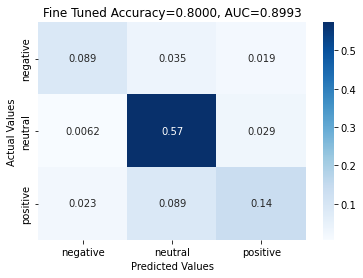

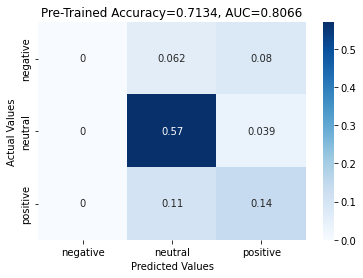

In [16]:
basebest_file = "hidden_last_6_layer_0.75.json"
base_file = "cls_embeddings_0.0_distilbert-base-cased_BASELINE_1651420556.json"

best_auc = 0.899284558823023
base_auc = 0.806630771748489

best_accuracy = 0.800000011920928
base_accuracy = 0.713402092456817 

plot_confusion(model_ground_truths[best_file], model_predictions[best_file], f"Fine Tuned Accuracy={best_accuracy:.04f}, AUC={best_auc:0.4f}")
plot_confusion(model_ground_truths[base_file], model_predictions[base_file].astype(bool), f"Pre-Trained Accuracy={base_accuracy:.04f}, AUC={base_auc:0.4f}")

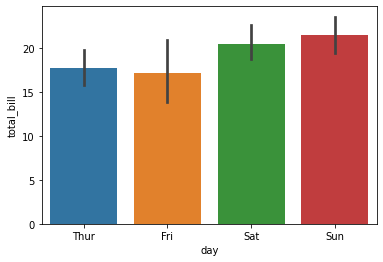

In [17]:
ax = sns.barplot(x=, y="total_bill", data=tips)